# CS 3110/5110: Data Privacy
## Homework 5

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

## Question 1 (5 points)

Implement the `dp_occupation_histogram` function below. It should return a differentially private histogram over the `Occupation` column in the `adult` dataset. Your function should have a total privacy cost of `epsilon` and should use parallel composition.

In [4]:
def dp_occupation_histogram(epsilon):
    counts = adult['Occupation'].value_counts()
    noisy_counts = counts.apply(lambda x: laplace_mech(x, sensitivity=1, epsilon=epsilon))
    return noisy_counts

dp_occupation_histogram(1.0)

Prof-specialty       4139.518336
Craft-repair         4102.079245
Exec-managerial      4066.624288
Adm-clerical         3772.639645
Sales                3649.839410
Other-service        3294.124314
Machine-op-inspct    1999.883680
Transport-moving     1596.338461
Handlers-cleaners    1370.814343
Farming-fishing       993.820356
Tech-support          927.609678
Protective-serv       650.385886
Priv-house-serv       149.073147
Armed-Forces            7.618393
Name: Occupation, dtype: float64

In [5]:
# TEST CASE
hist = adult['Occupation'].value_counts()
dp_results = [np.abs(dp_occupation_histogram(1.0)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/1.0) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 2
assert stats.wasserstein_distance(all_dp_results, spec) > 0

dp_results = [np.abs(dp_occupation_histogram(0.01)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/0.01) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 150
assert stats.wasserstein_distance(all_dp_results, spec) > 50

## Question 2 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your solution for `dp_occupation_histogram` satisfies `epsilon`-differential privacy.
- How would your results change (in terms of accuracy) if you used sequential composition instead of parallel composition to implement `dp_occupation_histogram`, and why?
- If you partition the data by *both* occupation and age (i.e. a contingency table), would parallel composition still apply? Why or why not?
- If you partition the data by both occupation and age, what would happen to accuracy, and why?

1. The `dp_occupation_histogram` function satisfies $\epsilon$-differential privacy by applying the Laplace Mechanism to each count in the histogram independently. Since each bin in the histogram represents a disjoint subset of the data (unique occupations), adding Laplace noise with scale $\delta/\epsilon = 1/\epsilon$ to each count ensures that the presence or absence of any single individual affects only one bin by at most the sensitivity $\delta = 1$. Utilizing parallel composition, where each mechanism operates on separate data subsets, guarantees that the overall privacy loss remains bounded by $\epsilon$. Therefore, the entire histogram maintains $\epsilon$-differential privacy.

2. If sequential composition were used instead of parallel composition, the total privacy loss would accumulate across all bins. Specifically, for a histogram with $k$ bins, the overall privacy parameter would become $k\epsilon$ instead of $\epsilon$. To maintain the same total privacy budget, each bin would need to use a smaller $\epsilon’ = \epsilon/k$, resulting in larger noise being added to each count (since noise scale is inversely proportional to $\epsilon’$). Consequently, the accuracy of the histogram would significantly decrease, as each bin’s count would be more heavily perturbed by the increased noise.

3. No, parallel composition would not directly apply when partitioning the data by both occupation and age in a contingency table. This is because each cell in the contingency table may overlap across different partitions of the data. For example, a single individual contributes to one cell based on their occupation and age, meaning that changes to an individual’s data can affect multiple cells. Since the mechanisms applied to these overlapping cells are not operating on disjoint subsets, the privacy losses cannot be independently bounded. Therefore, parallel composition does not hold in this scenario.

4. Partitioning the data by both occupation and age would decrease accuracy in the differentially private histogram. Since parallel composition does not apply, each cell in the contingency table would need to use a smaller portion of the total privacy budget to maintain the overall privacy guarantee. This reduction in the allocated $\epsilon$ per cell results in larger noise being added to each count to preserve privacy. Consequently, the noise introduced would be more substantial, leading to less accurate and more dispersed noisy counts across the contingency table.

## Question 3 (5 points)

Consider the code below, which graphs the total privacy cost of an averaging attack under (1) sequential composition and (2) advanced composition, for values of `k` between 1 and 200.

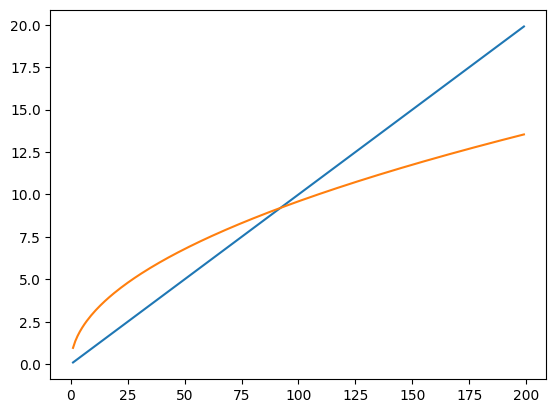

In [6]:
epsilon = .1
delta_p = 1e-5

def query():
    return len(adult_data[adult_data['Martial Status'] == 'Divorced'])

def avg_attack(k):
    return np.mean([laplace_mech(query(), 1, epsilon) for i in range(k)])
    
xs = range(1, 200)
privacy_cost_sequential = [k * epsilon for k in xs]
privacy_cost_advanced = [2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)) for k in xs]

plt.plot(xs, privacy_cost_sequential);
plt.plot(xs, privacy_cost_advanced);

In 2-5 sentences, answer the following:
- At approximately what point do the lines representing the two approaches cross? What does this mean about **which** composition technique should be used for an iterative algorithm?
- The two lines represent **different** privacy costs for the **same** algorithm. How can both be correct?

1. The lines representing sequential and advanced composition cross at approximately $k \approx 92$. This crossover point indicates that for fewer iterations ($k < 92$), advanced composition offers a lower total privacy cost compared to sequential composition. However, beyond this point ($k > 92$), sequential composition becomes more privacy-efficient. Therefore, for iterative algorithms with a small to moderate number of iterations, advanced composition should be preferred to minimize privacy loss, while sequential composition may be more suitable for a large number of iterations.

2. Both sequential and advanced composition lines are correct because they are based on different theoretical bounds for privacy loss under composition. Sequential composition sums the privacy loss linearly across all iterations, providing a straightforward but often looser bound. In contrast, advanced composition offers a tighter, sublinear bound by accounting for the cumulative effect of multiple mechanisms more efficiently. Therefore, depending on the number of iterations and the specific parameters, each composition method provides a valid upper bound on the total privacy cost for the same algorithm.


## Question 4 (10 points)

Consider the code below, which defines three average queries and runs them on `adult_data`, using the Laplace mechanism to provide differential privacy with $\epsilon = 1$ for each query.

In [ ]:
b_capgain = 10000
b_age = 3000

epsilon = 1

def query1():
    return np.sum(adult['Capital Gain'].clip(lower=0, upper=b_capgain))

def query2():
    return len(adult[adult['Education-Num'] < 10])

def query3():
    return np.sum(adult['Age'].clip(lower=0, upper=b_age))

def my_query():
    return [query1(), query2(), query3()]

my_query()

[17145231, 14754, 1256257]

In 2-5 sentences, answer the following:
- What is the $L_1$ global sensitivity of `my_query`, and why?
- What is the $L_2$ global sensitivity of `my_query`, and why?

1. The  $L_1$  global sensitivity of my_query is the sum of the maximum changes that a single individual can contribute to each query. For `query1`, an individual’s contribution to the sum of Capital Gain is at most  $b_{\text{capgain}} = 10,000$ . For `query2`, an individual can change the count by at most 1. For `query3`, the maximum contribution to the sum of Age is  $b_{\text{age}} = 3,000$ . Therefore, the  $L_1$  global sensitivity is  $10,000 + 1 + 3,000 = 13,001$ .

2. The  $L_2$  global sensitivity is the Euclidean norm of the maximum changes an individual can cause in the outputs. Using the same maximum contributions, the  $L_2$  sensitivity is  $\sqrt{(10,000)^2 + 1^2 + (3,000)^2} = \sqrt{100,000,000 + 1 + 9,000,000} = \sqrt{109,000,001} \approx 10,440.3$ .

## Question 5 (5 points)

In the cell below, write code to release the results of calling `my_query()` with differential privacy, without using sequential composition.

*Hint*: use `laplace_mech_vec`, but be careful of sensitivity!

In [8]:
def my_query_lap(epsilon):
    qs = my_query()
    
    s1 = b_capgain 
    s2 = 1   
    s3 = b_age   

    total_sensitivity = s1 + s2 + s3 
    
    noisy_qs = laplace_mech_vec(qs, sensitivity=total_sensitivity, epsilon=epsilon)
    
    return pd.Series(noisy_qs, index=['Capital Gain Sum', 'Education-Num Count', 'Age Sum'])

print(my_query_lap(1.0))

Capital Gain Sum       1.717277e+07
Education-Num Count    1.235282e+04
Age Sum                1.254016e+06
dtype: float64


### Question 6 (5 points)

In the cell below, write code to release the results of `my_query()` with differential privacy, but using the Gaussian mechanism.

*Hint*: remember to use $L_2$ sensitivity

In [10]:
def my_query_gauss(epsilon, delta):
    qs = my_query()

    l2_sensitivity = np.sqrt(b_capgain**2 + 1**2 + b_age**2)

    noisy_qs = gaussian_mech_vec(qs, sensitivity=l2_sensitivity, epsilon=epsilon, delta=delta)

    return pd.Series(noisy_qs, index=['Capital Gain Sum', 'Education-Num Count', 'Age Sum'])

my_query_gauss(1.0, 1e-5)

Capital Gain Sum       1.720128e+07
Education-Num Count    1.140060e+05
Age Sum                1.119041e+06
dtype: float64